In [1]:
from deepscribe2.datasets import PFADetectionDataModule
from deepscribe2.datasets.dataset import collate_retinanet
from deepscribe2.pipeline import DeepScribePipeline
import torch
from torchvision.utils import draw_bounding_boxes
from deepscribe2.evaluation import compute_cls_metrics, compute_cls_metrics_agged
from deepscribe2.models.detection.retinanet import RetinaNet
from deepscribe2.models.classification import ImageClassifier

import torchvision.transforms.functional as F


/local/ecw/venvs/deepscribe_public/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DETECTOR_ARTIFACT = "artifacts/trained_detector_public.ckpt"
CLASSIFIER_ARTIFACT = "artifacts/trained_classifier_public.ckpt"
DATA_DIR = "data/DeepScribe_Data_2023-02-04_public"

In [ ]:
pipeline = DeepScribePipeline.from_checkpoints(DETECTOR_ARTIFACT,
                                              classifier_ckpt=CLASSIFIER_ARTIFACT,
                                              score_thresh=0.3,
                                               device="cuda")



In [5]:
pfa_data_module_full = PFADetectionDataModule(
    DATA_DIR,
    autocrop=True, # this will trim images using the provided boxes.
    batch_size=8,
    train_xforms=[], # don't need to bother with these
    localization_only=False,
    start_from_one=False, # no need to increment this - the detector needs 0 to be background, but the classifier doesn't. 
)

# This will handle preprocessing/splitting the data. 
# random seed is fixed. 
pfa_data_module_full.prepare_data()

Autocrop directory found. Skipping.
Split files already exist, skipping.


In [6]:
pfa_data_module_full.setup(stage="test")

dataset = pfa_data_module_full.test_dataset

In [16]:
idx = 1
test_img, test_targets = collate_retinanet([dataset[idx]])

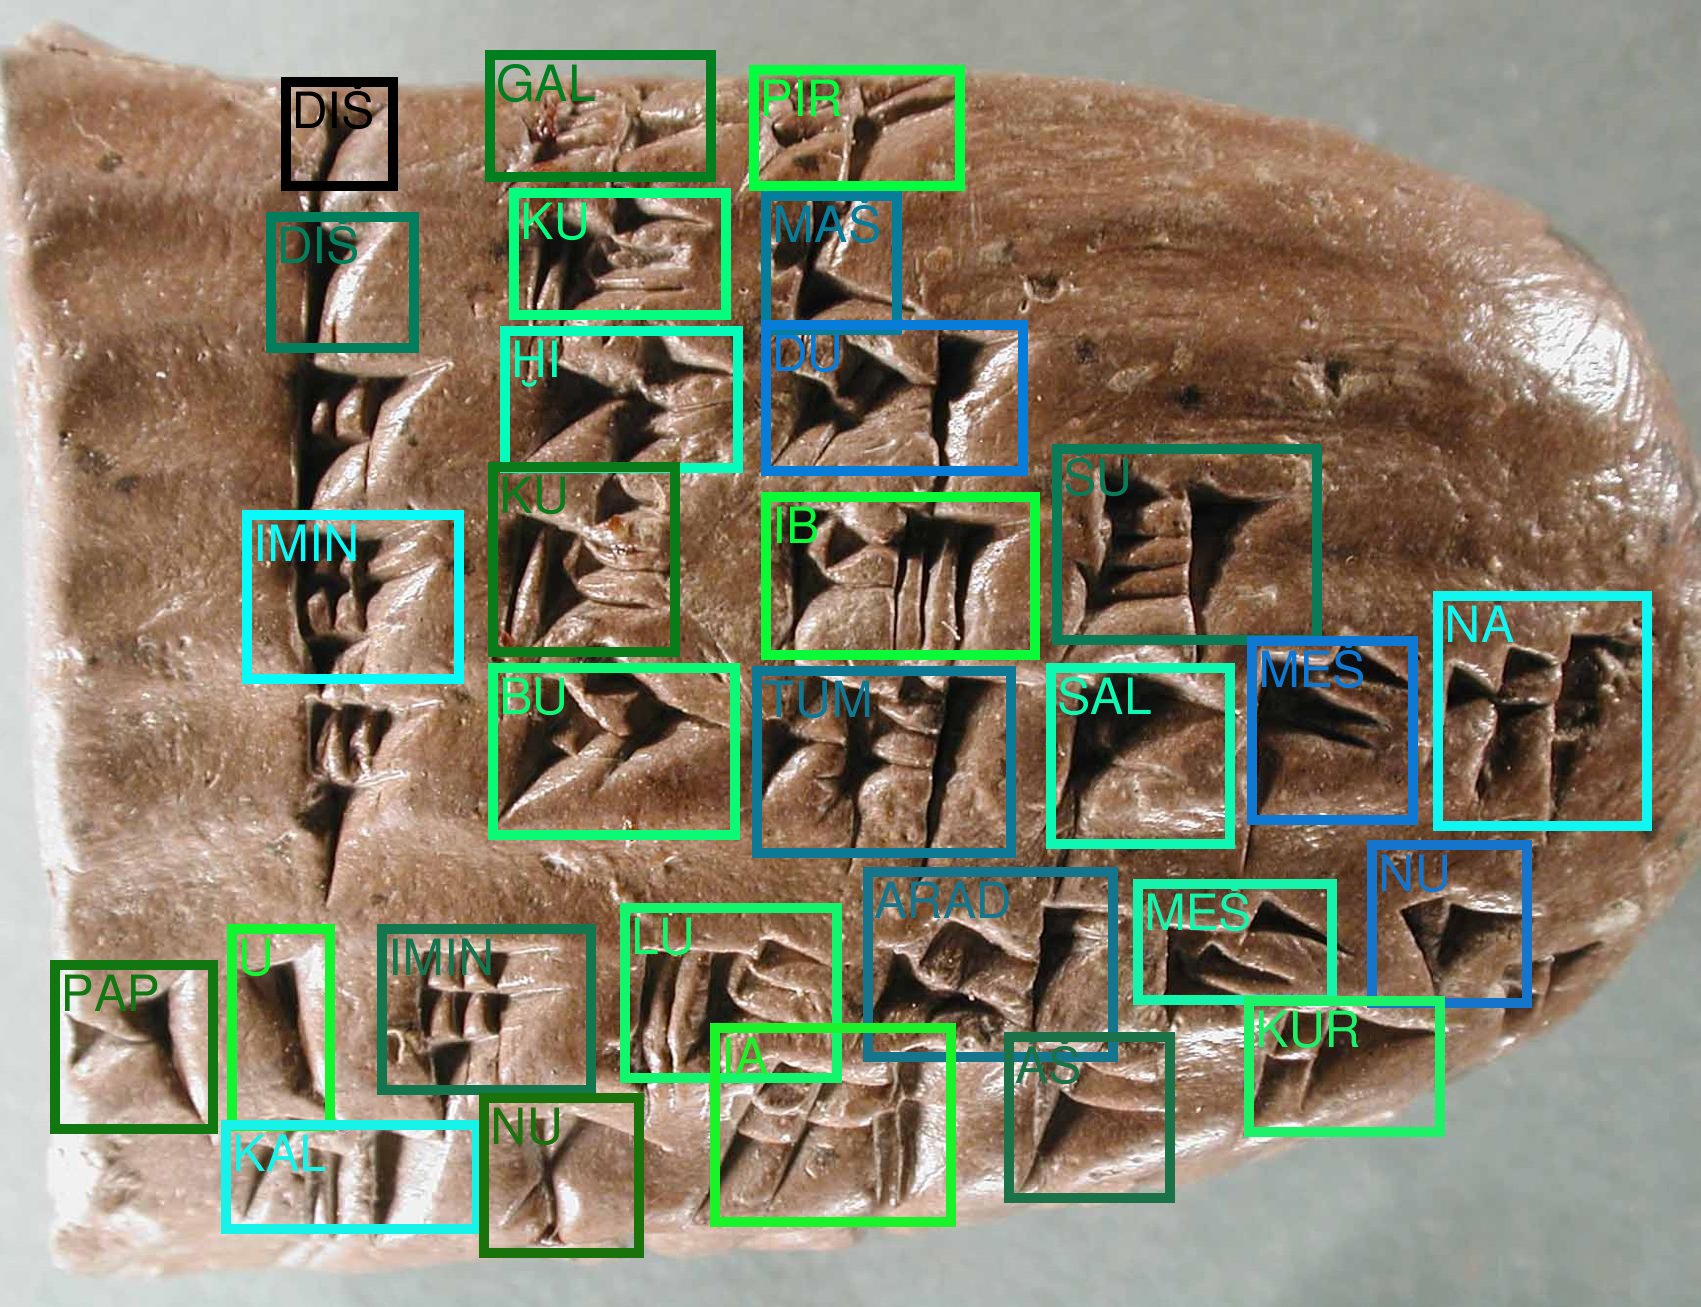

In [17]:
# ground truth boxes from test data
# draw sign classes
gt_signs = [pfa_data_module_full.class_labels[ind] for ind in test_targets[0]["labels"].tolist()]

rescaled_image = (test_img[0]*255).to(torch.uint8)
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   test_targets[0]["boxes"],
                                   width=10,
                                   labels=gt_signs,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [18]:
# run inference!
preds = pipeline(test_img)

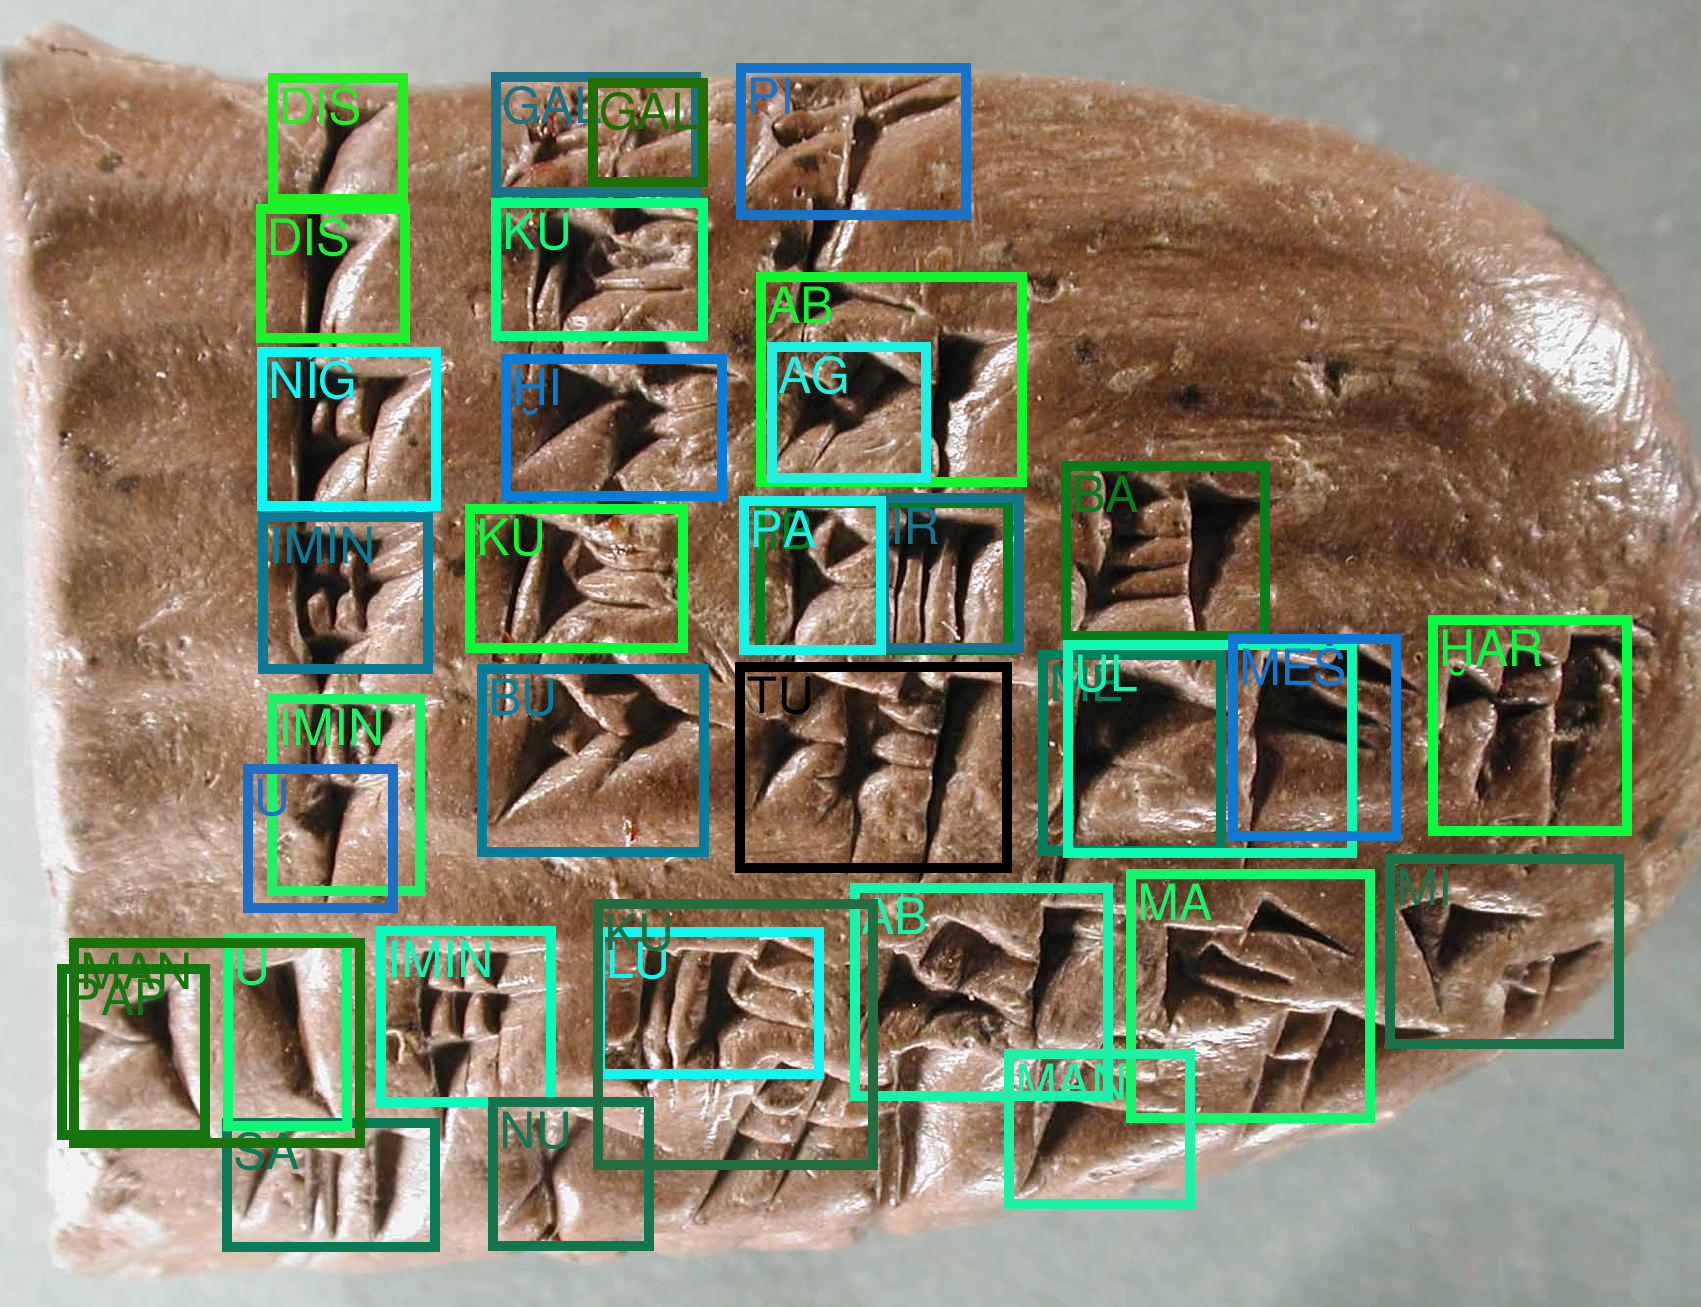

In [19]:
pred_labels = [pfa_data_module_full.class_labels[ind] for ind in preds[0]["labels"].tolist()]
# rendering with end-to-end predictions!
F.to_pil_image(draw_bounding_boxes(rescaled_image,
                                   preds[0]["boxes"],
                                   width=10,
                                   labels=pred_labels,
                                   font="/content/fonts/FreeSans.ttf",
                                  font_size=50))

In [20]:
import numpy as np
import editdistance

In [21]:
# what about the complete sentence transliteration?
pred_order = list(np.array(pred_labels)[np.array(preds[0]["ordering"])])
# not bad - but this is a pretty small tablet with only two straight lines. 
print(pred_order)
print(gt_signs)
# as you can tell from the picture, it's not terrible - although insertions and overlapping
# signs throw off the character error rate (CER). For large, multi-line tablets, this can 
# severely impact performance end-to-end even if the average sign prediction is good. 
print(editdistance.eval(pred_order, gt_signs) /len(gt_signs))

['DIŠ', 'DIŠ', 'GAL', 'KU', 'GAL', 'PI', 'NÍG', 'ḪI', 'AG', 'AB', 'IMIN', 'KU', 'PA', 'IB', 'IR', 'BA', 'U', 'IMIN', 'BU', 'TU', 'ME', 'UL', 'MEŠ', 'ḪAR', 'PAP', 'MAN', 'U', 'IMIN', 'LU', 'KU', 'AB', 'MA', 'MI', 'SA', 'NU', 'MAN']
['DIŠ', 'GAL', 'PÍR', 'DIŠ', 'KU', 'MAŠ', 'ḪI', 'DU', 'IMIN', 'KU', 'IB', 'ŠU', 'BU', 'TUM', 'SAL', 'MEŠ', 'NA', 'PAP', 'U', 'IMIN', 'LU', 'ARAD', 'MEŠ', 'NU', 'KAL', 'NU', 'IA', 'ÁŠ', 'KUR']
0.8620689655172413


In [1]:
pred_order

NameError: name 'pred_order' is not defined

In [7]:
# compute stats for everything!!

labels_all = []
preds_all = []

for imgs, labels in pfa_data_module_full.test_dataloader():
    # run inference!
    labels_all += labels
    with torch.no_grad():
        preds = pipeline([img.cuda() for img in imgs])
        preds_all += preds
        # preds_all += [combine_results(pred) for pred in preds]
preds_all = [{key:(val.cpu() if isinstance(val, torch.Tensor) else val) for key, val in pred.items()  }for pred in preds_all]

RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
RANSAC failed in batch elem 4


/local/ecw/venvs/deepscribe_public/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
RANSAC failed in batch elem 3
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the p

In [8]:
compute_cls_metrics_agged(labels_all, preds_all, iou_thresh=0.4)

{'fpr': 0.10790289808576622,
 'top1_acc': 0.5677467650518662,
 'top5_acc': 0.7651588065447545}